CELL 1 — IMPORT LIBRARY

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

CELL 2 — PATH & PARAMETER

In [2]:
BASE_DIR = "../processed_dataset"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(TRAIN_DIR))

print("Jumlah kelas:", NUM_CLASSES)
print("Nama kelas:", os.listdir(TRAIN_DIR))

Jumlah kelas: 12
Nama kelas: ['abyssinian', 'bengal', 'birman', 'bombay', 'british_shorthair', 'egyptian_mau', 'maine_coon', 'persian', 'ragdoll', 'russian_blue', 'siamese', 'sphynx']


CELL 3 — DATA GENERATOR

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 6632 images belonging to 12 classes.
Found 353 images belonging to 12 classes.
Found 360 images belonging to 12 classes.


CELL 4 — LOAD PRETRAINED RESNET50

In [4]:
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # FREEZE pretrained layers



94765736/94765736 [==============================] - 17s 0us/step


CELL 5 — BUILD MODEL TRANSFER LEARNING

In [5]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

CELL 6 — CALLBACK

In [6]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(
        "../models/resnet50_cat_breed.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]

CELL 7 — TRAINING MODEL

In [7]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


208/208 [==============================] - 407s 2s/step - loss: 2.6034 - accuracy: 0.0878 - val_loss: 2.4683 - val_accuracy: 0.1190
Epoch 2/20
208/208 [==============================] - 401s 2s/step - loss: 2.4778 - accuracy: 0.1054 - val_loss: 2.4554 - val_accuracy: 0.1275
Epoch 3/20
208/208 [==============================] - 401s 2s/step - loss: 2.4611 - accuracy: 0.1175 - val_loss: 2.4458 - val_accuracy: 0.1388
Epoch 4/20
208/208 [==============================] - 376s 2s/step - loss: 2.4517 - accuracy: 0.1292 - val_loss: 2.4344 - val_accuracy: 0.1756
Epoch 5/20
208/208 [==============================] - 398s 2s/step - loss: 2.4456 - accuracy: 0.1212 - val_loss: 2.4245 - val_accuracy: 0.1445
Epoch 6/20
208/208 [==============================] - 396s 2s/step - loss: 2.4353 - accuracy: 0.1312 - val_loss: 2.4132 - val_accuracy: 0.1530
Epoch 7/20
208/208 [==============================] - 388s 2s/step - loss: 2.4293 - accuracy: 0.1369 - val_loss: 2.4004 - val_accuracy: 0.15

CELL 8 — GRAFIK LOSS & ACCURACY

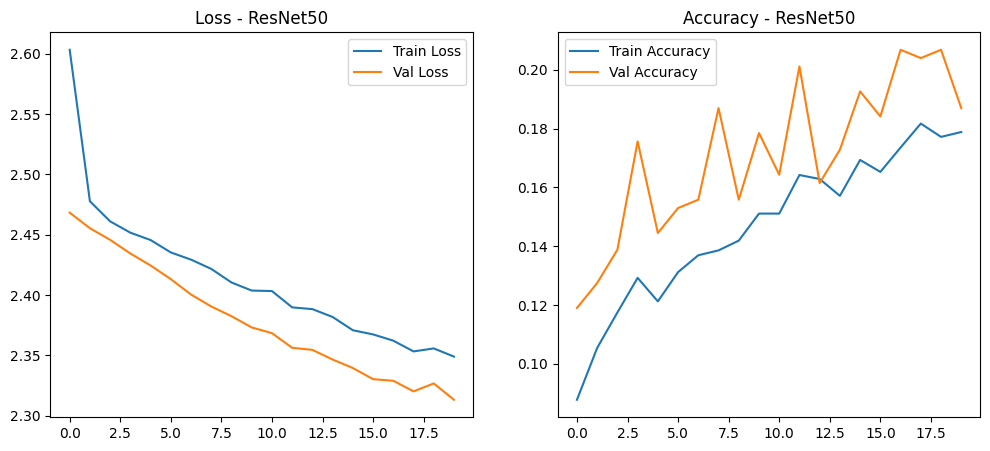

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss - ResNet50")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy - ResNet50")
plt.legend()

plt.show()

CELL 9 — EVALUASI TEST SET

In [9]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

12/12 [==============================] - 23s 2s/step - loss: 2.3270 - accuracy: 0.2139
Test Accuracy: 0.21388888359069824


CELL 10 — CLASSIFICATION REPORT

In [10]:
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

class_labels = list(test_gen.class_indices.keys())

print(classification_report(
    y_true,
    y_pred,
    target_names=class_labels
))

12/12 [==============================] - 22s 2s/step
                   precision    recall  f1-score   support

       abyssinian       0.20      0.03      0.06        31
           bengal       0.24      0.53      0.33        30
           birman       0.17      0.17      0.17        30
           bombay       0.26      0.17      0.21        29
british_shorthair       0.12      0.10      0.11        30
     egyptian_mau       0.38      0.10      0.16        29
       maine_coon       1.00      0.03      0.06        30
          persian       0.15      0.77      0.26        30
          ragdoll       0.00      0.00      0.00        30
     russian_blue       0.00      0.00      0.00        30
          siamese       0.40      0.19      0.26        31
           sphynx       0.33      0.47      0.39        30

         accuracy                           0.21       360
        macro avg       0.27      0.21      0.17       360
     weighted avg       0.27      0.21      0.17       360



e:\UAP\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\UAP\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\UAP\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


CELL 11 — CONFUSION MATRIX

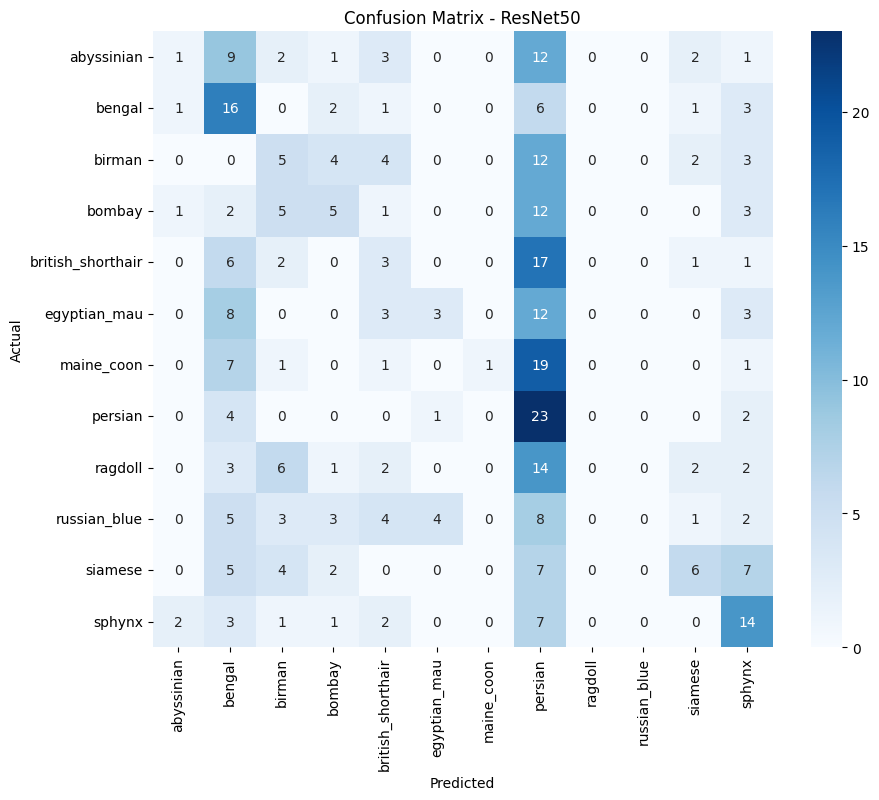

In [11]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ResNet50")
plt.show()

CELL 12 — SAVE FINAL MODEL (BACKUP)

In [12]:
model.save("../models/resnet50_cat_breed_final.keras")
print("✅ Model ResNet50 berhasil disimpan")

✅ Model ResNet50 berhasil disimpan
